In [121]:
from unstructured.partition.pdf import partition_pdf
pdf_file_path = "/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf"

raw_elements = partition_pdf(
    filename=pdf_file_path,
    chunking_strategy="by_title",
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    image_output_dir_path="./images/",
    max_characters=1000,
    new_after_n_chars=1500,
    combine_text_under_n_chars=250,
    strategy='hi_res',
)

KeyboardInterrupt: 

In [1]:
!pip install --upgrade jpype1 tabula-py PyMuPDF

DEPRECATION: Loading egg at /Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 243.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 238.5 kB/s eta 0:00:0000:0100:03


In [11]:
pip install pdfminer.six

DEPRECATION: Loading egg at /Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tabula
import faiss
import json
import base64
import pymupdf
import requests
import os
import logging
import numpy as np
import warnings
from tqdm import tqdm
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython import display

In [5]:
# Create the directories
def create_directories(base_dir):
    directories = ["images", "text", "tables", "page_images"]
    for dir in directories:
        os.makedirs(os.path.join(base_dir, dir), exist_ok=True)

# Process tables
def process_tables(doc, page_num, base_dir, items):
    try:
        tables = tabula.read_pdf(filepath, pages=page_num + 1, multiple_tables=True)
        if not tables:
            return
        for table_idx, table in enumerate(tables):
            table_text = "\n".join([" | ".join(map(str, row)) for row in table.values])
            table_file_name = f"{base_dir}/tables/{os.path.basename(filepath)}_table_{page_num}_{table_idx}.txt"
            with open(table_file_name, 'w') as f:
                f.write(table_text)
            items.append({"page": page_num, "type": "table", "text": table_text, "path": table_file_name})
    except Exception as e:
        print(f"Error extracting tables from page {page_num}: {str(e)}")

# Process text chunks
def process_text_chunks(text, text_splitter, page_num, base_dir, items):
    chunks = text_splitter.split_text(text)
    for i, chunk in enumerate(chunks):
        text_file_name = f"{base_dir}/text/{os.path.basename(filepath)}_text_{page_num}_{i}.txt"
        with open(text_file_name, 'w') as f:
            f.write(chunk)
        items.append({"page": page_num, "type": "text", "text": chunk, "path": text_file_name})

# Process images
def process_images(page, page_num, base_dir, items):
    images = page.get_images()
    for idx, image in enumerate(images):
        xref = image[0]
        pix = pymupdf.Pixmap(doc, xref)
        image_name = f"{base_dir}/images/{os.path.basename(filepath)}_image_{page_num}_{idx}_{xref}.png"
        pix.save(image_name)
        with open(image_name, 'rb') as f:
            encoded_image = base64.b64encode(f.read()).decode('utf8')
        items.append({"page": page_num, "type": "image", "path": image_name, "image": encoded_image})

# Process page images
def process_page_images(page, page_num, base_dir, items):
    pix = page.get_pixmap()
    page_path = os.path.join(base_dir, f"page_images/page_{page_num:03d}.png")
    pix.save(page_path)
    with open(page_path, 'rb') as f:
        page_image = base64.b64encode(f.read()).decode('utf8')
    items.append({"page": page_num, "type": "page", "path": page_path, "image": page_image})

In [6]:
filepath="/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf"
doc = pymupdf.open(filepath)
num_pages = len(doc)
base_dir = "data"

# Creating the directories
create_directories(base_dir)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200, length_function=len)
items = []

# Process each page of the PDF
for page_num in tqdm(range(num_pages), desc="Processing PDF pages"):
    page = doc[page_num]
    text = page.get_text()
    process_tables(doc, page_num, base_dir, items)
    process_text_chunks(text, text_splitter, page_num, base_dir, items)
    process_images(page, page_num, base_dir, items)
    process_page_images(page, page_num, base_dir, items)

Processing PDF pages:   0%|          | 0/15 [00:00<?, ?it/s]Feb 05, 2025 4:26:47 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
Feb 05, 2025 4:26:47 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Feb 05, 2025 4:26:47 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider addTrueTypeFontImpl
Feb 05, 2025 4:26:49 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Processing PDF pages: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


In [7]:
import nest_asyncio

nest_asyncio.apply()

In [23]:
from dotenv import load_dotenv
load_dotenv()

# bring in deps
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader

parser = LlamaParse(
    result_type="markdown",
    premium_mode=True,
    # invalidate_cache=True
)
print(f"Parsing text...")
md_json_objs = parser.get_json_result("/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf")

Parsing text...
Started parsing the file under job_id 7aa10234-b91a-41ed-9950-63374077154d


In [24]:
md_json_objs[0]['pages'][5]['items']

[{'type': 'table',
  'rows': [['Layer Type',
    'Complexity per Layer',
    'Sequential Operations',
    'Maximum Path Length'],
   ['Self-Attention', 'O(n² · d)', 'O(1)', 'O(1)'],
   ['Recurrent', 'O(n · d²)', 'O(n)', 'O(n)'],
   ['Convolutional', 'O(k · n · d²)', 'O(1)', 'O(logk(n))'],
   ['Self-Attention (restricted)', 'O(r · n · d)', 'O(1)', 'O(n/r)']],
  'md': '| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |\n|------------|----------------------|------------------------|------------------------|\n| Self-Attention | O(n² · d) | O(1) | O(1) |\n| Recurrent | O(n · d²) | O(n) | O(n) |\n| Convolutional | O(k · n · d²) | O(1) | O(logk(n)) |\n| Self-Attention (restricted) | O(r · n · d) | O(1) | O(n/r) |',
  'isPerfectTable': True,
  'csv': '"Layer Type","Complexity per Layer","Sequential Operations","Maximum Path Length"\n"Self-Attention","O(n² · d)","O(1)","O(1)"\n"Recurrent","O(n · d²)","O(n)","O(n)"\n"Convolutional","O(k · n · d²)","O(1)","O(logk(

In [25]:
data = md_json_objs[0]['pages'][5]['items']
items = md_json_objs[0]['pages'][4]
items

{'page': 5,
 'text': ' Multi-head attention allows the model to jointly attend to information from different representation\n subspaces at different positions. With a single attention head, averaging inhibits this.\n\n\n\n                                                                                                   MultiHead(Q, K, V ) = Concat(head1, ..., headh)W O\n                                                                                                                                                  where headi = Attention(QW i\n                                                                                                                                                                                          Q, KW i          K, V W i        V)\nWhere the projections are parameter matrices W i ∈ Rdmodel×dk , W i ∈ Rdmodel×dk , W i ∈ Rdmodel×dv                                                                                                Q                 K  V\n and W O 

In [26]:
# Initialize separate lists for tables and texts
table_list = []
text_list = []

# Iterate through items
i = 0
items = items.get('items', [])
while i < len(items):
    item = items[i]
    if item['type'] == 'table':
        # Add the table's markdown to table_list (or use 'value' if preferred)
        table_list.append(item.get('md', item.get('value', '')))
        i += 1  # Move to next item
    elif item['type'] == 'heading':
        # Check if the next item is text to combine with heading
        heading_md = item.get('md', item.get('value', ''))
        combined_text = heading_md
        if i + 1 < len(items) and items[i + 1]['type'] == 'text':
            text_md = items[i + 1].get('md', items[i + 1].get('value', ''))
            combined_text = f"{heading_md}\n\n{text_md}"
            i += 2  # Skip the next item as it is merged
        else:
            i += 1
        text_list.append(combined_text)
    elif item['type'] == 'text':
        # Standalone text item (not preceded by a heading)
        text_list.append(item.get('md', item.get('value', '')))
        i += 1
    else:
        # For any other type, simply skip or handle accordingly
        i += 1

# Display the results:
print("Tables:")
for t in table_list:
    print("-----")
    print(t)

print("\nTexts:")
for txt in text_list:
    print("-----")
    print(txt)

Tables:

Texts:
-----
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

$$\text{where } \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

Where the projections are parameter matrices $W_i^Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W_i^K \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_v}$
and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h = 8$ parallel attention layers, or heads. For each of these we use
$d_k = d_v = d_{\text{model}}/h = 64$. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.
-----
### 3.2.3 Applications of Attention in our Model

The Transformer uses multi-head 

In [27]:
table_list = []
text_list = []

# Iterate through all pages
pages = md_json_objs[0]['pages']  
for page in pages:
    items = page['items'] 
    i = 0
    while i < len(items):
        item = items[i]
        if item['type'] == 'table':
            table_list.append(item.get('md', item.get('value', '')))
            i += 1
        elif item['type'] == 'heading':
            # Check if the next item is text to combine with heading
            heading_md = item.get('md', item.get('value', ''))
            combined_text = heading_md
            if i + 1 < len(items) and items[i + 1]['type'] == 'text':
                text_md = items[i + 1].get('md', items[i + 1].get('value', ''))
                combined_text = f"{heading_md}\n\n{text_md}"
                i += 2  # Skip the next item as it is merged
            else:
                i += 1
            text_list.append(combined_text)
        elif item['type'] == 'text':
            text_value = item.get('md', item.get('value', ''))
            normalized_text = " ".join(text_value.split())
            text_list.append(normalized_text)
            i += 1
        else:
            i += 1

# print the results:
print("Tables:")
for table in table_list:
    print("-----")
    print(table)

print("\nTexts:")
for text in text_list:
    print("-----")
    print(text)


Tables:
-----
| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |
|------------|----------------------|------------------------|------------------------|
| Self-Attention | O(n² · d) | O(1) | O(1) |
| Recurrent | O(n · d²) | O(n) | O(n) |
| Convolutional | O(k · n · d²) | O(1) | O(logk(n)) |
| Self-Attention (restricted) | O(r · n · d) | O(1) | O(n/r) |
-----
| Model | BLEU | Training Cost (FLOPs) |
|-------|------|------------------------|
| | EN-DE | EN-FR | EN-DE | EN-FR |
| ByteNet [18] | 23.75 | | | |
| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |
| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |
| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |
| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |
| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |
| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |
| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |
| Transformer (base mod

In [28]:
table_list = []
text_list = []

# Iterate through all pages
pages = md_json_objs[0]['pages']
for page in pages:
    items = page['items']  # items on the current page
    i = 0
    while i < len(items):
        item = items[i]
        if item['type'] == 'table':
            table_list.append(item.get('md', item.get('value', '')))
            i += 1 

        elif item['type'] == 'heading':
            # Process heading and check if the next item is text to merge
            heading_md = item.get('md', item.get('value', ''))
            heading_md = " ".join(heading_md.split())
            combined_text = heading_md

            # If the heading is immediately followed by a text item, merge them.
            if i + 1 < len(items) and items[i + 1]['type'] == 'text':
                text_md = items[i + 1].get('md', items[i + 1].get('value', ''))
                text_md = " ".join(text_md.split())
                combined_text = f"{heading_md}\n\n{text_md}"
                i += 2  # Skip the merged text item
            else:
                i += 1

            text_list.append(combined_text)

        elif item['type'] == 'text':
            # For standalone text (not immediately following a heading)
            text_value = item.get('md', item.get('value', ''))
            normalized_text = " ".join(text_value.split())

            # Append this text to the previous text_list item (if it exists)
            if text_list:
                text_list[-1] += "\n\n" + normalized_text
            else:
                # If there's no previous text, add it as a new item.
                text_list.append(normalized_text)
            i += 1

        else:
            i += 1

# print the results:
print("Tables:")
for table in table_list:
    print("-----")
    print(table)

print("\nTexts:")
for text in text_list:
    print("-----")
    print(text)


Tables:
-----
| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |
|------------|----------------------|------------------------|------------------------|
| Self-Attention | O(n² · d) | O(1) | O(1) |
| Recurrent | O(n · d²) | O(n) | O(n) |
| Convolutional | O(k · n · d²) | O(1) | O(logk(n)) |
| Self-Attention (restricted) | O(r · n · d) | O(1) | O(n/r) |
-----
| Model | BLEU | Training Cost (FLOPs) |
|-------|------|------------------------|
| | EN-DE | EN-FR | EN-DE | EN-FR |
| ByteNet [18] | 23.75 | | | |
| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |
| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |
| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |
| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |
| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |
| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |
| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |
| Transformer (base mod

In [29]:
table_list

['| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |\n|------------|----------------------|------------------------|------------------------|\n| Self-Attention | O(n² · d) | O(1) | O(1) |\n| Recurrent | O(n · d²) | O(n) | O(n) |\n| Convolutional | O(k · n · d²) | O(1) | O(logk(n)) |\n| Self-Attention (restricted) | O(r · n · d) | O(1) | O(n/r) |',
 '| Model | BLEU | Training Cost (FLOPs) |\n|-------|------|------------------------|\n| | EN-DE | EN-FR | EN-DE | EN-FR |\n| ByteNet [18] | 23.75 | | | |\n| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |\n| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |\n| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |\n| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |\n| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |\n| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |\n| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |\n| Transformer (base m

In [30]:
image_dicts = parser.get_images(md_json_objs, download_path="../images")
image_dicts

> Images for page 1: [{'name': 'page_1.jpg', 'height': 792, 'width': 612, 'x': 0, 'y': 0, 'original_width': 1236, 'original_height': 1600, 'type': 'full_page_screenshot'}]
> Images for page 2: [{'name': 'page_2.jpg', 'height': 792, 'width': 612, 'x': 0, 'y': 0, 'original_width': 1236, 'original_height': 1600, 'type': 'full_page_screenshot'}]
> Images for page 3: [{'name': 'img_p2_1.png', 'height': 2239, 'width': 1520, 'x': 196.559, 'y': 72.00200000000001, 'original_width': 1520, 'original_height': 2239, 'ocr': [{'x': 930, 'y': 0, 'w': 204, 'h': 76, 'confidence': '0.9680109534671366', 'text': 'Output'}, {'x': 865, 'y': 75, 'w': 334, 'h': 64, 'confidence': '0.7139761078758757', 'text': 'Probabilities'}, {'x': 930, 'y': 218, 'w': 202, 'h': 54, 'confidence': '0.9999439487386765', 'text': 'Softmax'}, {'x': 956, 'y': 358, 'w': 150, 'h': 52, 'confidence': '0.9085299062147066', 'text': 'Linear'}, {'x': 886, 'y': 514, 'w': 290, 'h': 54, 'confidence': '0.6760768239123691', 'text': 'Add & Norm'},

[{'name': 'page_1.jpg',
  'height': 792,
  'width': 612,
  'x': 0,
  'y': 0,
  'original_width': 1236,
  'original_height': 1600,
  'type': 'full_page_screenshot',
  'path': '../images/7aa10234-b91a-41ed-9950-63374077154d-page_1.jpg',
  'job_id': '7aa10234-b91a-41ed-9950-63374077154d',
  'original_file_path': '/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf',
  'page_number': 1},
 {'name': 'page_2.jpg',
  'height': 792,
  'width': 612,
  'x': 0,
  'y': 0,
  'original_width': 1236,
  'original_height': 1600,
  'type': 'full_page_screenshot',
  'path': '../images/7aa10234-b91a-41ed-9950-63374077154d-page_2.jpg',
  'job_id': '7aa10234-b91a-41ed-9950-63374077154d',
  'original_file_path': '/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf',
  'page_number': 2},
 {'name': 'img_p2_1.png',
  'height': 2239,
  'width': 1520,
  'x': 196.559,
  'y': 72.00200000000001,
  'original_width': 1520,
  'original_h

In [31]:
len(text_list)

25

In [32]:
for i, chunk in enumerate(text_list):
    print(f"----- Chunk {i} -----")
    print(len(chunk))

----- Chunk 0 -----
493
----- Chunk 1 -----
1152
----- Chunk 2 -----
3023
----- Chunk 3 -----
1830
----- Chunk 4 -----
3034
----- Chunk 5 -----
1651
----- Chunk 6 -----
1801
----- Chunk 7 -----
1219
----- Chunk 8 -----
697
----- Chunk 9 -----
558
----- Chunk 10 -----
1736
----- Chunk 11 -----
3204
----- Chunk 12 -----
73
----- Chunk 13 -----
627
----- Chunk 14 -----
429
----- Chunk 15 -----
493
----- Chunk 16 -----
585
----- Chunk 17 -----
12
----- Chunk 18 -----
1699
----- Chunk 19 -----
1721
----- Chunk 20 -----
1698
----- Chunk 21 -----
1104
----- Chunk 22 -----
133
----- Chunk 23 -----
7017
----- Chunk 24 -----
1367


In [38]:
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [43]:
summarize_prompt = """
You are an assistant responsible for summarizing the provided {element_type} from the "Attention is all you need" paper. 
Your task is to generate a concise summary of the content found in the chunk below.

Instructions:
- Respond only with the summary.
- Do not include any additional commentary, greetings, or extra text.
- Do not begin your response with phrases like "Here is a summary" or similar introductions.
- Simply output the summary as it is.
- Pay special attention to any comparisons mentioned within the chunk; ensure that all comparative insights are clearly noted.
- Do not discard any information that might be useful—retain all details that could aid in understanding or comparing the content.

Chunk: {element}
"""
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(summarize_prompt)
# chain = LLMChain(llm=llm, prompt=prompt)
summarize_chain = (prompt | llm | StrOutputParser())

# text_summarizis = []
# # summarize_text
# for element in text_list:
#     summary = summarize_chain.run({
#         'element_type': 'text', 'element': element
#     })
#     text_summarizis.append(summary)
text_inputs = [{"element_type": "text", "element": text} for text in text_list[:15]]
text_summaries = summarize_chain.batch(text_inputs)

In [44]:
text_summaries

['The provided chunk appears to be an author list and affiliation section from the "Attention Is All You Need" paper, listing researchers from Google Brain and Google Research, as well as the University of Toronto, with no comparative insights or content summaries available in this specific section, only presenting the authors and their respective institutions, including Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin.',
 'The proposed Transformer model, based solely on attention mechanisms, outperforms existing sequence transduction models that rely on recurrent or convolutional neural networks. Compared to the best performing models, the Transformer achieves superior quality, is more parallelizable, and requires significantly less training time. Specifically, it improves over the existing best results by over 2 BLEU on the WMT 2014 English-to-German translation task, achieving a BLEU score of 28.4, and estab

In [45]:
table_list

['| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |\n|------------|----------------------|------------------------|------------------------|\n| Self-Attention | O(n² · d) | O(1) | O(1) |\n| Recurrent | O(n · d²) | O(n) | O(n) |\n| Convolutional | O(k · n · d²) | O(1) | O(logk(n)) |\n| Self-Attention (restricted) | O(r · n · d) | O(1) | O(n/r) |',
 '| Model | BLEU | Training Cost (FLOPs) |\n|-------|------|------------------------|\n| | EN-DE | EN-FR | EN-DE | EN-FR |\n| ByteNet [18] | 23.75 | | | |\n| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |\n| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |\n| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |\n| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |\n| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |\n| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |\n| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |\n| Transformer (base m

In [48]:
llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-001",
        convert_system_message_to_human=False)
summarize_chain = (prompt | llm | StrOutputParser())

inputs = [{"element_type": "table", "element": text} for text in table_list]
tables_summs = summarize_chain.batch(inputs)

In [49]:
tables_summs

['This table compares the complexity per layer, sequential operations, and maximum path length of self-attention, recurrent, and convolutional layers. Self-attention has a complexity of O(n²d), recurrent layers have O(nd²), and convolutional layers have O(knd²). Self-attention and convolutional layers have constant sequential operations O(1), while recurrent layers have O(n). Maximum path length is O(1) for self-attention, O(n) for recurrent, and O(logk(n)) for convolutional layers. A restricted self-attention mechanism is also presented, with complexity O(rnd), constant sequential operations O(1), and a maximum path length of O(n/r).',
 'ByteNet achieves a BLEU score of 23.75 on EN-DE. Deep-Att + PosUnk reaches a BLEU of 39.2 on EN-FR with a training cost of 1.0 · 10^20 FLOPs. GNMT + RL scores 24.6 (EN-DE) and 39.92 (EN-FR) BLEU with 2.3 · 10^19 and 1.4 · 10^20 FLOPs, respectively. ConvS2S attains 25.16 (EN-DE) and 40.46 (EN-FR) BLEU with 9.6 · 10^18 and 1.5 · 10^20 FLOPs, respectivel

In [51]:
for summ in text_summaries:
    print(len(summ))

497
939
1177
1090
1498
991
1206
912
510
520
782
1413
277
538
533


In [52]:
image_paths = []

for image in image_dicts:
    image_paths.append(image['path'])
    

image_paths = [path for path in image_paths if not path.lower().endswith('.jpg')]

In [54]:
import base64

def encode(img):
  with open(img,'rb') as f:
    return base64.b64encode(f.read()).decode('utf-8')

encoded_images = []
for img in image_paths:
    encoded_images.append(encode(img))

In [ ]:
def encode_image(img_path):
        """Encode image to base64 string"""
        with open(img_path,'rb') as f:
            return base64.b64encode(f.read()).decode('utf-8')

def process_images(obj):
        """Download images from PDF and encode as base64"""
        encoded_images = []
        image_dicts = self.parser.get_images(obj, download_path=self.image_download_path)
        for image in image_dicts:
            encoded_images.append(self.encode_image(image['path']))
        return encoded_images


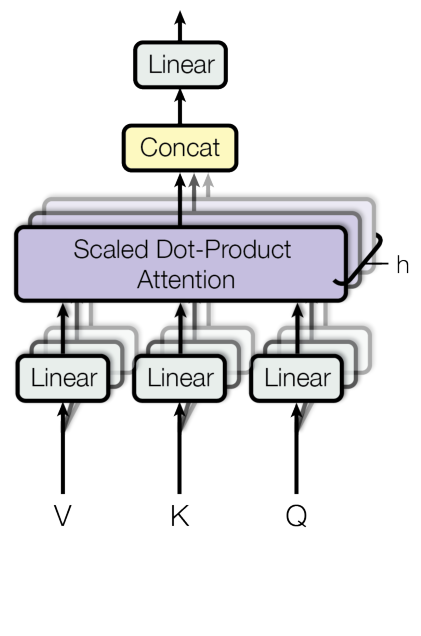

In [56]:
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(encoded_image):
    # Decode the base64 string
    img_bytes = base64.b64decode(encoded_image)
    
    img = Image.open(io.BytesIO(img_bytes))
    
    # Create figure and axes
    plt.figure(figsize=(10, 8))
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

display_base64_image(encoded_images[2])

In [57]:
from langchain.schema.messages import HumanMessage, SystemMessage
load_dotenv()
from langchain_core.output_parsers import StrOutputParser

prompt=[
      SystemMessage(content="You are a bot that is good at analyzing images related to attention is all you need's paper"),
      HumanMessage(content=[
          {
              "type":"text",
              "text":"Explain elaborately about the content of image without stating the word image or diagram or other related word."
          },
          {
              "type":"image_url",
              "image_url":{
                  "url":f'data:image/jpeg;base64,{img}'
              }
          }
      ])
  ]
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
vision_llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", convert_system_message_to_human=True)
chain = (prompt | vision_llm | StrOutputParser())
image_summaries = chain.batch(encoded_images)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'list'>

In [245]:
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI


prompt_template = """
You are an expert in analyzing images from the 'Attention Is All You Need' paper. 
Your task is to provide a detailed, technical breakdown of the given image. 

- If the image contains a graph, describe the axes, labels, and key trends. Identify whether it is a bar chart, line plot, or scatter plot, and explain what it represents.
- If the image contains a diagram, break it down into key components, explaining their roles in the Transformer architecture.
- If the image contains mathematical notation, provide an interpretation of the equations or symbols.
- If the image represents text, summarize its content concisely.
"""
messages = [
    (
        "user", 
        [
            {"type": "text", "text": prompt_template},
            {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
        ]
    )
]
prompt = ChatPromptTemplate.from_messages(messages)
vision_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", convert_system_message_to_human=False)
chain = (
    prompt 
    | vision_llm 
    | StrOutputParser()
)

# 4. Process images with proper input mapping
image_summaries = chain.batch(encoded_images)

In [246]:
image_summaries

['The image is a diagram illustrating the architecture of the Transformer model, as introduced in the "Attention Is All You Need" paper. It shows both the encoder and decoder components of the Transformer.\n\n**Key Components and their Roles:**\n\n1.  **Inputs/Outputs:** The bottom of the diagram shows the "Inputs" and "Outputs (shifted right)". This refers to the input sequence and the target sequence (shifted by one position to the right for autoregressive prediction) to the model.\n\n2.  **Input Embedding/Output Embedding:** The input and output sequences are first transformed into embeddings. These embeddings are dense vector representations of the input and output tokens.\n\n3.  **Positional Encoding:** Since the Transformer doesn\'t inherently capture the order of the input sequence, positional encoding is added to the input and output embeddings. This provides information about the position of each token in the sequence. The diagram shows a sine wave symbol to represent position

In [60]:
for sume in image_summaries:
    print(len(sume))

4888
1979
1948


In [160]:
class Parser:
    def __init__(self, pdf_path: str, image_download_path: str="../images"):
        super().__init__()
        self.pdf_path = pdf_path
        self.image_download_path = image_download_path
        self.parser = LlamaParse(
            result_type="markdown",
            # invalidate_cache=True
        )


    def parse_docs(self):
        print("Parsing text...")
        return self.parser.get_json_result(self.pdf_path)


    def encode_image(self, img_path):
        with open(img_path,'rb') as f:
            return base64.b64encode(f.read()).decode('utf-8')


    def process_images(self, obj):
        print("Processing images...")
        encoded_images = []
        image_dicts = self.parser.get_images(obj, download_path=self.image_download_path)
        for image in image_dicts:
            encoded_images.append(self.encode_image(image['path']))
        return encoded_images


    def extract_content(self, items):
        table_list = []
        text_list = []
        i = 0
        while i < len(items):
            item = items[i]
            if item['type'] == 'table':
                table_list.append(item.get('md', item.get('value', '')))
                i += 1
            elif item['type'] == 'heading':
                # Process heading and check if the next item is text to merge
                heading_md = item.get('md', item.get('value', ''))
                heading_md = ' '.join(heading_md.split())
                combined_text = heading_md

                # If the heading is immediately followed by a text item, merge them.
                if i + 1 < len(items) and items[i + 1]['type'] == 'text':
                    text_md = items[i + 1].get('md', items[i + 1].get('value', ''))
                    text_md = ' '.join(text_md.split())
                    combined_text = f"{heading_md}\n\n{text_md}"
                    i += 2  # Skip the merged text item
                else:
                    i += 1

                text_list.append(combined_text)
            elif item['type'] == 'text':
                # For standalone text (not immediately following a heading)
                text_value = item.get('md', item.get('value', ''))
                normalized_text = ' '.join(text_value.split())

                # Append this text to the previous text_list item (if it exists)
                if text_list:
                    text_list[-1] += "\n\n" + normalized_text
                else:
                    # If there's no previous text, add it as a new item.
                    text_list.append(normalized_text)
                i += 1
            else:
                i += 1

        return text_list, table_list


    def process(self):
        md_json_objs = self.parse_docs()
        images_list = self.process_images(md_json_objs)

        table_list = []
        text_list = []

        # Iterate through all pages
        pages = md_json_objs[0]['pages']

        for page in pages:
            items = page['items']
            page_text, page_tables = self.extract_content(items)
            if page_text:
                text_list.append(page_text)
            if page_tables:
                table_list.append(page_tables)

        return images_list, text_list, table_list


In [162]:
parse = Parser("/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf")
imgs, txts, tabls = parse.process()

Parsing text...
Started parsing the file under job_id 7bb47fe5-b64e-4639-9141-4e493f7a2563
Processing images...
> Images for page 1: []
> Images for page 2: []
> Images for page 3: [{'name': 'img_p2_1.png', 'height': 2239, 'width': 1520, 'x': 196.559, 'y': 72.00200000000001, 'original_width': 1520, 'original_height': 2239, 'ocr': [{'x': 930, 'y': 0, 'w': 204, 'h': 76, 'confidence': '0.9680109534671366', 'text': 'Output'}, {'x': 865, 'y': 75, 'w': 334, 'h': 64, 'confidence': '0.7139761078758757', 'text': 'Probabilities'}, {'x': 930, 'y': 218, 'w': 202, 'h': 54, 'confidence': '0.9999439487386765', 'text': 'Softmax'}, {'x': 956, 'y': 358, 'w': 150, 'h': 52, 'confidence': '0.9085299062147066', 'text': 'Linear'}, {'x': 886, 'y': 514, 'w': 290, 'h': 54, 'confidence': '0.6760768239123691', 'text': 'Add & Norm'}, {'x': 970, 'y': 606, 'w': 122, 'h': 56, 'confidence': '0.7896517311300871', 'text': 'Feed'}, {'x': 932, 'y': 670, 'w': 196, 'h': 54, 'confidence': '0.780785328082077', 'text': 'Forwar

In [64]:

import uuid
from langchain_core.documents import Document

def make_docs(element, summary, context_type, docs, retrieved_docs):
        for e, s in zip(element, summary):
            i=str(uuid.uuid4())
            doc = Document(
                page_content=s,
                metadata={
                    'id': i,
                    'type': context_type,
                    'original_context': e
                }
            )
            docs.append(doc)
            retrieved_docs.append((i, e))


def idknow(texts, tables, images):
        documents = []
        retrieved_contents=[]
        make_docs(texts, text_summaries, 'text', documents, retrieved_contents)
        make_docs(tables, tables_summs, 'table', documents, retrieved_contents)
        make_docs(images, image_summaries, 'image', documents, retrieved_contents)

        return documents, retrieved_contents

docs, retrieved_docs = idknow(text_list[:15], table_list, encoded_images)

In [65]:
docs

[Document(metadata={'id': '4aeab2c8-7438-44b0-b041-dbeae62b4002', 'type': 'text', 'original_context': '# Attention Is All You Need\n\nAshish Vaswani* | Noam Shazeer* | Niki Parmar* | Jakob Uszkoreit* --- | --- | --- | --- Google Brain | Google Brain | Google Research | Google Research avaswani@google.com | noam@google.com | nikip@google.com | usz@google.com Llion Jones* | Aidan N. Gomez* † | Łukasz Kaiser* --- | --- | --- Google Research | University of Toronto | Google Brain llion@google.com | aidan@cs.toronto.edu | lukaszkaiser@google.com Illia Polosukhin* ‡ ---- illia.polosukhin@gmail.com'}, page_content='The provided chunk appears to be an author list and affiliation section from the "Attention Is All You Need" paper, listing researchers from Google Brain and Google Research, as well as the University of Toronto, with no comparative insights or content summaries available in this specific section, only presenting the authors and their respective institutions, including Ashish Vaswa

In [66]:
retrieved_docs

[('4aeab2c8-7438-44b0-b041-dbeae62b4002',
  '# Attention Is All You Need\n\nAshish Vaswani* | Noam Shazeer* | Niki Parmar* | Jakob Uszkoreit* --- | --- | --- | --- Google Brain | Google Brain | Google Research | Google Research avaswani@google.com | noam@google.com | nikip@google.com | usz@google.com Llion Jones* | Aidan N. Gomez* † | Łukasz Kaiser* --- | --- | --- Google Research | University of Toronto | Google Brain llion@google.com | aidan@cs.toronto.edu | lukaszkaiser@google.com Illia Polosukhin* ‡ ---- illia.polosukhin@gmail.com'),
 ('91eef8bd-e2b5-4d37-9147-a0f5b5ab17d6',
  '## Abstract\n\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. 

In [218]:
from langchain.vectorstores import Qdrant
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_cohere import CohereEmbeddings
import uuid
from langchain.schema import Document
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

# Initialize Qdrant client
client = QdrantClient()  # For local in-memory instance
# For production, use:
# client = QdrantClient(host="localhost", port=6333)  # Local installation
# client = QdrantClient(url="<your-qdrant-url>", api_key="<your-api-key>")  # Cloud

# Create collection
# collection_name = "multi_rag"
# client.create_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=1024, distance=Distance.COSINE)  # Adjust size based on your embedding model
# )

# Initialize vectorstore with Qdrant
vectorstore = Qdrant(
    client=client,
    collection_name="multi_rag",
    embeddings=CohereEmbeddings(model="embed-english-v3.0"),
)

# Initialize storage and retriever
store = InMemoryStore()
id_key = "doc_id"
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

def add_summary_to_retriever(elements, summaries, retriever, id_key):
    doc_ids = [str(uuid.uuid4()) for _ in elements]
    summary_docs = [
        Document(page_content=summary, metadata={id_key: doc_ids[i]})
        for i, summary in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, elements)))

# Add your documents
add_summary_to_retriever(text_list[:15], text_summaries, retriever, id_key)
add_summary_to_retriever(table_list, tables_summs, retriever, id_key)
add_summary_to_retriever(encoded_images, image_summaries, retriever, id_key)

ResponseHandlingException: [Errno 61] Connection refused

In [224]:
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_cohere import CohereEmbeddings

vectorstore = Chroma(collection_name="multi_rag", embedding_function=CohereEmbeddings(model = "embed-english-v3.0"))
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [225]:
def add_summary_to_retriever(elements, summaries, retriever, id_key):
    doc_ids = [str(uuid.uuid4()) for _ in elements]
    summary_docs = [
        Document(page_content=summary, metadata={id_key: doc_ids[i]})
        for i, summary in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, elements)))

In [226]:
add_summary_to_retriever(text_list[:15], text_summaries, retriever, id_key)
add_summary_to_retriever(table_list, tables_summs, retriever, id_key)
add_summary_to_retriever(encoded_images, image_summaries, retriever, id_key)


In [210]:
docs = retriever.invoke(
    "what is multihead attention"
)

In [211]:
docs

['## 3.2.2 Multi-Head Attention\n\nInstead of performing a single attention function with d<sub>model</sub>-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to d<sub>k</sub>, d<sub>k</sub> and d<sub>v</sub> dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding d<sub>v</sub>-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2. ---- <sup>4</sup>To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, q · k = Σ<sup>d<sub>k</sub></sup><sub>i=1</sub> q<sub>i</sub>k<sub>i</sub>, has mean 0 and variance d<sub>k</sub>. 4\n\nMulti-head attention allows the model to jointly attend to information from di

In [85]:
"""Building the retriever"""
import uuid
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from prompts import TEXT_TABLE_SUMMARIZATION, IMAGE_SUMMARIZATION


class Retriever:
    def __init__(self, llm, embedding_model):
        super().__init__()
        self.llm =llm
        self.embedding_model = embedding_model


    def summarize_text_tables(self, texts, tables):
        prompt = PromptTemplate.from_template(TEXT_TABLE_SUMMARIZATION)
        summarization_chain = prompt | self.llm | StrOutputParser()

        # summarize texts
        text_inputs = [{"element_type": "text", "element": text} for text in texts]
        text_summaries = summarization_chain.batch(text_inputs)

        # summarize tables
        tables_inputs = [{"element_type": "table", "element": table} for table in tables]
        tables_summaries = summarization_chain.batch(tables_inputs)

        return text_summaries, tables_summaries


    def summrize_images(self, images):
        messages = [
            (
                "user", 
                [
                    {"type": "text", "text": IMAGE_SUMMARIZATION},
                    {"type": "image_url", "image_url": 
                    {"url": "data:image/jpeg;base64,{image_data}"}}
                ]
            )
        ]
        prompt = ChatPromptTemplate.from_messages(messages)
        summarization_chain = prompt | self.llm | StrOutputParser()
        image_summaries = summarization_chain.batch(images)
        return image_summaries


    # def make_docs(self, element, summary, context_type, docs):
    #     for e, s in zip(element, summary):
    #         i=str(uuid.uuid4())
    #         doc = Document(
    #             page_content=s,
    #             metadata={
    #                 'id': i,
    #                 'type': context_type,
    #                 'original_context': e
    #             }
    #         )
    #         docs.append(doc)


    def add_summary_to_retriever(self, elements, summaries, retriever, id_key):
        doc_ids = [str(uuid.uuid4()) for _ in elements]
        summary_docs = [
             Document(page_content=summary, metadata={id_key: doc_ids[i]})
            for i, summary in enumerate(summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, elements)))


    def make_retriever(self, texts, tables, images, texts_summary, tables_summary, images_summary):
        vectorstore = Chroma(
            collection_name="xBites_multi_model", 
            embedding_function=self.embedding_model
        )
        store = InMemoryStore()
        id_key = "doc_id"

        retriever = MultiVectorRetriever(
            vectorstore=vectorstore,
            docstore=store,
            id_key=id_key,
        )

        # getting the text, tables and images summaries
        # texts_summary, tables_summary = self.summarize_text_tables(texts, tables)
        # images_summary = self.summrize_images(images)

        self.add_summary_to_retriever(texts, texts_summary, retriever, id_key)
        self.add_summary_to_retriever(tables, tables_summary, retriever, id_key)
        self.add_summary_to_retriever(images, images_summary, retriever, id_key)

        return retriever


In [92]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-001",
        convert_system_message_to_human=False)

embed = CohereEmbeddings(model = "embed-english-v3.0")
# embed = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

ret = Retriever(llm, embed)
rett = ret.make_retriever(text_list[:15], table_list, encoded_images, text_summaries, tables_summs, image_summaries)

In [274]:
docs = rett.invoke(
    "what is multihead attention"
)
docs

['## 3.2.2 Multi-Head Attention\n\nInstead of performing a single attention function with d<sub>model</sub>-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to d<sub>k</sub>, d<sub>k</sub> and d<sub>v</sub> dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding d<sub>v</sub>-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2. ---- <sup>4</sup>To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, q · k = Σ<sup>d<sub>k</sub></sup><sub>i=1</sub> q<sub>i</sub>k<sub>i</sub>, has mean 0 and variance d<sub>k</sub>. 4\n\nMulti-head attention allows the model to jointly attend to information from di

In [250]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_documents(docs):
        b64 = []
        text = []
        for doc in docs:
            try:
                b64decode(doc)
                b64.append(doc)
            except Exception:
                text.append(doc)
        return {"images": b64, "texts": text}

def building_prompt(settings):
    docs = settings["context"]
    question = settings["question"]

    context_text = ""
    if len(docs["texts"]) > 0:
        for text_element in docs["texts"]:
            context_text += text_element


    # construct prompt with context (including images)
    prompt_template = f"""
    You are an AI engineering expert analyzing multimodal documents, you task is to answer the user quesiton
    . Follow these rules:

    1. Context Analysis:
    - Examine text for technical concepts and relationships
    - Use you knowledge base to evaluate the formulas if they written wrong
    - For tables: 
    * Identify key numerical values and their relationships
    * Look for trends, comparisons, and statistical patterns
    * Cross-reference with other context elements
    - For images: Extract visual data relevant to technical analysis

    2. Response Requirements:
    - Maintain objective, professional tone
    - Structure answer: 
    [Key Findings] -> [Technical Analysis]
    - Format numerical data prominently (bold/table)
    - Use markdown formatting
    - Never disclose your reasoning process

    3. If context is insufficient:
    - Request clarification on specific missing elements
    - Never speculate beyond provided evidence
    Context: {context_text}
    Question: {question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]
    if len(docs["images"]) > 0:
        for image in docs["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain_with_sources = {
    "context": retriever | RunnableLambda(parse_documents),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(building_prompt)
        | ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
        | StrOutputParser()
    )
)

response = chain_with_sources.invoke(
    "What is the BLEU score of the model in English to German translation EN-DE?"
)

print("response:", response['response'])

response: ### BLEU Score Analysis for EN-DE Translation

**Key Findings:**

*   Multiple models are evaluated for English to German (EN-DE) translation.
*   The BLEU scores range from 23.75 to 28.4.
*   The highest BLEU score is achieved by "Transformer (big)" with a score of **28.4**.

**Technical Analysis:**

The provided table includes BLEU scores for various models on EN-DE translation tasks. Below are some of the models and their corresponding BLEU scores:

| Model                       | BLEU (EN-DE) |
| --------------------------- | ------------ |
| ByteNet [18]                | 23.75        |
| GNMT + RL [38]              | 24.6         |
| ConvS2S [9]                 | 25.16        |
| MoE [32]                    | 26.03        |
| GNMT + RL Ensemble [38]     | 26.30        |
| ConvS2S Ensemble [9]        | 26.36        |
| Transformer (base model)    | 27.3         |
| Transformer (big)           | **28.4**   |

**Conclusion:**

The "Transformer (big)" model achieves the high

In [242]:
response

{'context': {'images': [],
  'texts': ['| Model | BLEU | Training Cost (FLOPs) |\n|-------|------|------------------------|\n| | EN-DE | EN-FR | EN-DE | EN-FR |\n| ByteNet [18] | 23.75 | | | |\n| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |\n| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |\n| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |\n| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |\n| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |\n| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |\n| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |\n| Transformer (base model) | 27.3 | 38.1 | 3.3 · 10^18 | |\n| Transformer (big) | 28.4 | 41.8 | 2.3 · 10^19 | |',
   '| | N | d_model | d_ff | h | d_k | d_v | P_drop | ε_ls | train steps | PPL (dev) | BLEU (dev) | params ×10^6 |\n|---|---|---------|------|---|-----|-----|--------|------|------------|-----------|------------|---------------|\n| base | 6 | 512 | 204

In [294]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_documents(docs):
        b64 = []
        text = []
        for doc in docs:
            try:
                b64decode(doc)
                b64.append(doc)
            except Exception:
                text.append(doc)
        return {"images": b64, "texts": text}

def building_prompt(settings):
    docs = settings["context"]
    question = settings["question"]

    context_text = ""
    if len(docs["texts"]) > 0:
        for text_element in docs["texts"]:
            context_text += text_element


    # construct prompt with context (including images)
    prompt_template = f"""
    You are an AI engineering expert analyzing multimodal documents, you task is to answer the user quesiton
    . Follow these rules:

    1. Context Analysis:
    - Examine text for technical concepts and relationships
    - For tables: 
    * Identify key numerical values and their relationships
    * Look for trends, comparisons, and statistical patterns
    * Cross-reference with other context elements
    - For images: Extract visual data relevant to technical analysis

    2. Response Requirements:
    - Maintain objective, professional tone
    - Structure answer: 
    [Header] -> [Key Findings] -> [Technical Analysis] -> [Conclusion]
    - Format numerical data prominently (bold/table)
    - Use markdown formatting
    - Never disclose your reasoning process

    3. If context is insufficient:
    - Request clarification on specific missing elements
    - Never speculate beyond provided evidence
    Context: {context_text}
    Question: {question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]
    if len(docs["images"]) > 0:
        for image in docs["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain_with_sources = {
    "context": retriever | RunnableLambda(parse_documents),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(building_prompt)
        | ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
        | StrOutputParser()
    )
)

response = chain_with_sources.invoke(
    "what is multihead attention"
)

response

{'context': {'images': ['iVBORw0KGgoAAAANSUhEUgAAA0MAAAUCCAYAAADIFCgcAAAACXBIWXMAAAPoAAAD6AG1e1JrAAAgAElEQVR4nOzdedxdZXnv/+u0WgREUXEqVQjVYK22UNvaARWZQYYACTMSwyTzIBBCQiYSCJlJQEjCEAiBTIQEEoYEQgADMogBGYpAQW17etoeD/2157R9/X7ndf9e18NaceVm7b2Gvda+1vD54/1q5cmz17XX2vvZ93ff930tcc4JAKD/RGRXEVloXQcAAK6lzAsAgLYSkdkiov/Pjta1AADgWsi8AABoKxF5NwhDF1rXAgCAayHzAgCgjURkeBCE1DvW9QAA4FrIvAAAaCMR2RgJQ2pv65oAAHAtY14AALSNiOzhBSFFIwUAAFx/mRcAAG2jwScmDKldrWsDAMC1iHkBANAm2jku0jjBN966PgAAXIuYFwAALW6c4KORAgAArn/MCwCANhGRzV3CkBpiXSMAAK4lzAsAgLbQjnEJQUitsq4TAADXEuYFAEBbdGmcQCMFAABc/5kXAAAtapyQJgjRSAEAANcf5gUAQBuIyIUZwtC71vUCAOBawLwAAGgD7RSXIQyp4dY1AwDgGs68AABoupSNE3wbresGAMA1nHkBANB0GRon0EgBAADXP+YFAECTaaDJGYTUbOv6AQBwDWZeAAA0mXaG6yEMvatd6KyfAwAArqHMCwCAJsvROIFGCgAAuP4wLwAAmkpEhvQYhNRm6+cBAIBrKPMCAKCpRGRVAWFI7WH9XAAAcA1kXgAANFGPjRN8C62fDwAAroHMCwCAJtJOcAWGIRopAADgimdeAAA0URBgXIEutH5OAAC4hjEvAACaRjvAFRyE1DvWzwsAANcw5gUAQNOIyMYOS90Wpgg9N3X4fbW39XMDAMA1iHkBANCCxgkagnbUMJMiDI2PtOX271FEIwUAAFxxzAsAgCbxZn82RmdzsoSh4N9rgBr

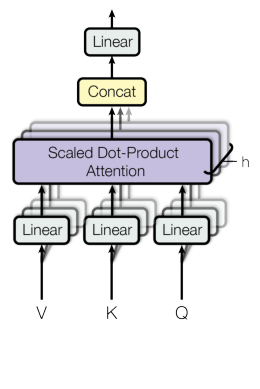

In [290]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

for idx, base64_string in enumerate(response['context']['images']):
    # Decode the Base64 string.
    image_data = base64.b64decode(base64_string)
    
    # Open the image.
    image = Image.open(io.BytesIO(image_data))
    
    # Create a new figure for each image.
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {idx+1}")
    plt.show()

In [241]:
def call_llm(llm, prompt: str):
    response = llm.invoke(prompt)
    return response.content


call_llm(llm, "This is a test context")

'Okay, I understand. I\'m ready to process any information or instructions you provide within this "test context." Just let me know what you\'d like me to do.'

In [256]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

response_eval = llm.invoke(question_groundedness_critique_prompt.format(context=response["context"], question=response["question"]))

In [255]:
response

{'context': {'images': [],
  'texts': ['| Model | BLEU | Training Cost (FLOPs) |\n|-------|------|------------------------|\n| | EN-DE | EN-FR | EN-DE | EN-FR |\n| ByteNet [18] | 23.75 | | | |\n| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |\n| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |\n| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |\n| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |\n| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |\n| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |\n| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |\n| Transformer (base model) | 27.3 | 38.1 | 3.3 · 10^18 | |\n| Transformer (big) | 28.4 | 41.8 | 2.3 · 10^19 | |',
   '| | N | d_model | d_ff | h | d_k | d_v | P_drop | ε_ls | train steps | PPL (dev) | BLEU (dev) | params ×10^6 |\n|---|---|---------|------|---|-----|-----|--------|------|------------|-----------|------------|---------------|\n| base | 6 | 512 | 204

In [258]:
response_eval.content

'Evaluation:The table in the context provides BLEU scores for various models in English to German translation (EN-DE). The question can be answered directly by extracting the BLEU scores from the table.\n\nTotal rating: 5'

In [261]:
def question_groundedness(response):
        question_groundedness_critique_prompt = """
        You will be given a context and a question.
        Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
        Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

        Provide your answer as follows:

        Answer:::
        Evaluation: (your rationale for the rating, as a text)
        Total rating: (your rating, as a number between 1 and 5)

        You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

        Now here are the question and context.

        Question: {question}\n
        Context: {context}\n
        Answer::: """

        prompt = question_groundedness_critique_prompt.format(
            context=response["context"],
            question=response["question"],
        )
        response = (llm.invoke(prompt)).content

        # Extract the evaluation text (everything between "Evaluation:" and "Total rating:")
        eval_match = re.search(r"Evaluation:\s*(.*?)\s*Total rating:", response, re.DOTALL)
        evaluation_text = eval_match.group(1).strip() if eval_match else None

        # Extract the total rating (digits following "Total rating:")
        rating_match = re.search(r"Total rating:\s*(\d+)", response)
        total_rating = rating_match.group(1) if rating_match else None

        return evaluation_text, total_rating

eval_text, total_rating = question_groundedness(response)
print("Evaluation:", evaluation_text)
print("Total rating:", total_rating)

Evaluation: The context provides a table with Model names and their corresponding BLEU scores for English to German translation (EN-DE). Therefore, the question can be answered directly from the context.
Total rating: 5


In [269]:
def response_reference_similarity(response, reference_response):
        EVALUATION_PROMPT = """
        ###Task Description:
        An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
        1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
        2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.

        Answer:::
        Evaluation: (your rationale for the rating, as a text in one line maximum)
        Total rating: (your rating, as a number between 1 and 5)

        Please do not generate any other opening, closing, and explanations. Be sure to include 'Total rating' in your output.
        ###The instruction to evaluate:
        {instruction}

        ###Response to evaluate:
        {response}

        ###Reference Answer (Score 5):
        {reference_answer}

        ###Score Rubrics:
        [Is the response correct, accurate, and factual based on the reference answer?]
        Score 1: The response is completely incorrect, inaccurate, and/or not factual.
        Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
        Score 3: The response is somewhat correct, accurate, and/or factual.
        Score 4: The response is mostly correct, accurate, and factual.
        Score 5: The response is completely correct, accurate, and factual.

        ###Evaluation:"""

        prompt = EVALUATION_PROMPT.format(
            instruction=response["question"],
            response=response["context"],
            reference_answer=reference_response
        )
        evaluation = (llm.invoke(prompt)).content

        return evaluation


reference_response = """
Here are the BLEU scores for English to German (EN-DE) translation:
*   ByteNet: 23.75
*   GNMT + RL: 24.6
*   ConvS2S: 25.16
*   MoE: 26.03
*   GNMT + RL Ensemble: 26.30
*   ConvS2S Ensemble: 26.36
*   Transformer (base model): 27.3
*   Transformer (big): 28.4"""

evalu = response_reference_similarity(response, reference_response)

In [270]:
evalu

'Evaluation:The response provides relevant information but it is presented in a difficult-to-read format.\nTotal rating: 3'

In [271]:
# Extract the evaluation text (everything between "Evaluation:" and "Total rating:")
eval_match = re.search(r"Evaluation:\s*(.*?)\s*Total rating:", evalu, re.DOTALL)
evaluation_text = eval_match.group(1).strip() if eval_match else None

# Extract the total rating (digits following "Total rating:")
rating_match = re.search(r"Total rating:\s*(\d+)", evalu)
total_rating = rating_match.group(1) if rating_match else None

print("Evaluation:", evaluation_text)
print("Total rating:", total_rating)

Evaluation: The response provides relevant information but it is presented in a difficult-to-read format.
Total rating: 3


In [272]:
def extract_evaluation_score(text):
        eval_match = re.search(r"Evaluation:\s*(.*?)\s*Total rating:", text, re.DOTALL)
        evaluation_text = eval_match.group(1).strip() if eval_match else None

        # Extract the total rating (digits following "Total rating:")
        rating_match = re.search(r"Total rating:\s*(\d+)", text)
        total_rating = rating_match.group(1) if rating_match else None

        return evaluation_text, total_rating

def question_groundedness(response):

        question_groundedness_critique_prompt = """
        You will be given a context and a question.
        Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
        Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

        Provide your answer as follows:

        Answer:::
        Evaluation: (your rationale for the rating, as a text)
        Total rating: (your rating, as a number between 1 and 5)

        You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

        Now here are the question and context.

        Question: {question}\n
        Context: {context}\n
        Answer::: """

        prompt = question_groundedness_critique_prompt.format(
            context=response["context"],
            question=response["question"],
        )
        response = (llm.invoke(prompt)).content

        return extract_evaluation_score(response)

question_groundedness(response)

('The context provides a table of BLEU scores for different models on English to German translation (EN-DE). Therefore, the question can be answered directly from the context.',
 '5')

In [248]:
import re

text = (
    "Evaluation:The context provides a table with Model names and their corresponding BLEU scores for English to German translation (EN-DE). "
    "Therefore, the question can be answered directly from the context.\n\nTotal rating: 5"
)

# Extract the evaluation text (everything between "Evaluation:" and "Total rating:")
eval_match = re.search(r"Evaluation:\s*(.*?)\s*Total rating:", text, re.DOTALL)
evaluation_text = eval_match.group(1).strip() if eval_match else None

# Extract the total rating (digits following "Total rating:")
rating_match = re.search(r"Total rating:\s*(\d+)", text)
total_rating = rating_match.group(1) if rating_match else None

print("Evaluation:", evaluation_text)
print("Total rating:", total_rating)


Evaluation: The context provides a table with Model names and their corresponding BLEU scores for English to German translation (EN-DE). Therefore, the question can be answered directly from the context.
Total rating: 5


In [238]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_documents(docs):
        b64 = []
        text = []
        for doc in docs:
            try:
                b64decode(doc)
                b64.append(doc)
            except Exception:
                text.append(doc)
        return {"images": b64, "texts": text}

def building_prompt(settings):
    docs = settings["context"]
    question = settings["question"]

    context_text = ""
    if len(docs["texts"]) > 0:
        for text_element in docs["texts"]:
            context_text += text_element


    # construct prompt with context (including images)
    prompt_template = f"""
        Using the information contained in the context that could be text or tables or images,
        give a comprehensive answer to the question.
        
        Before answering, analyze the question, identify relevant context details, and think through the logical steps to reach your conclusion
        Do not show your thinking process in the response
        Respond only to the question asked, response should be concise and relevant to the question.
        If the answer cannot be deduced from the context, do not give an answer.
        
        Provided Context:  
        {context_text}
        
        The question you need to answer:
        {question}
"""

    prompt_content = [{"type": "text", "text": prompt_template}]
    if len(docs["images"]) > 0:
        for image in docs["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain_with_sources = {
    "context": retriever | RunnableLambda(parse_documents),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(building_prompt)
        | ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
        | StrOutputParser()
    )
)

response = chain_with_sources.invoke(
    "What is the BLEU score of the model in English to German translation EN-DE?"
)

print("response:", response['response'])

response: Here are the BLEU scores for English to German (EN-DE) translation:

*   ByteNet: 23.75
*   GNMT + RL: 24.6
*   ConvS2S: 25.16
*   MoE: 26.03
*   GNMT + RL Ensemble: 26.30
*   ConvS2S Ensemble: 26.36
*   Transformer (base model): 27.3
*   Transformer (big): 28.4


In [247]:
response

{'context': {'images': [],
  'texts': ['| Model | BLEU | Training Cost (FLOPs) |\n|-------|------|------------------------|\n| | EN-DE | EN-FR | EN-DE | EN-FR |\n| ByteNet [18] | 23.75 | | | |\n| Deep-Att + PosUnk [39] | | 39.2 | | 1.0 · 10^20 |\n| GNMT + RL [38] | 24.6 | 39.92 | 2.3 · 10^19 | 1.4 · 10^20 |\n| ConvS2S [9] | 25.16 | 40.46 | 9.6 · 10^18 | 1.5 · 10^20 |\n| MoE [32] | 26.03 | 40.56 | 2.0 · 10^19 | 1.2 · 10^20 |\n| Deep-Att + PosUnk Ensemble [39] | | 40.4 | | 8.0 · 10^20 |\n| GNMT + RL Ensemble [38] | 26.30 | 41.16 | 1.8 · 10^20 | 1.1 · 10^21 |\n| ConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7 · 10^19 | 1.2 · 10^21 |\n| Transformer (base model) | 27.3 | 38.1 | 3.3 · 10^18 | |\n| Transformer (big) | 28.4 | 41.8 | 2.3 · 10^19 | |',
   '| | N | d_model | d_ff | h | d_k | d_v | P_drop | ε_ls | train steps | PPL (dev) | BLEU (dev) | params ×10^6 |\n|---|---|---------|------|---|-----|-----|--------|------|------------|-----------|------------|---------------|\n| base | 6 | 512 | 204

In [154]:
import base64
from llama_parse import LlamaParse


class Parser:
    """Parse PDF documents into structured text, tables, and images."""
    def __init__(self, pdf_path: str, image_download_path: str="../images"):
        """
        Args:
            pdf_path: Path to input PDF file.
            image_download_path: Directory to save extracted images. Defaults to "../images".

        Returns (from process()):
            tuple: (base64_images, cleaned_texts, markdown_tables)
        """
        super().__init__()
        self.pdf_path = pdf_path
        self.image_download_path = image_download_path
        self.parser = LlamaParse(
            result_type="markdown",
            # invalidate_cache=True
        )


    def parse_docs(self):
        """Parse PDF into structured JSON/Markdown"""
        return self.parser.get_json_result(self.pdf_path)


    def encode_image(self, img_path):
        """Encode image to base64 string"""
        with open(img_path,'rb') as f:
            return base64.b64encode(f.read()).decode('utf-8')


    def process_images(self, obj):
        """Download images from PDF and encode as base64"""
        encoded_images = []
        image_dicts = self.parser.get_images(obj, download_path=self.image_download_path)
        for image in image_dicts:
            encoded_images.append(self.encode_image(image['path']))
        return encoded_images


    def extract_content(self, items):
        """Extract and organize text/tables for each page"""
        table_list = []
        text_list = []
        i = 0
        while i < len(items):
            item = items[i]
            if item['type'] == 'table':
                table_list.append(item.get('md', item.get('value', '')))
                i += 1
            elif item['type'] == 'heading':
                # Process heading and check if the next item is text to merge
                heading_md = item.get('md', item.get('value', ''))
                heading_md = ' '.join(heading_md.split())
                combined_text = heading_md

                # If the heading is immediately followed by a text item, merge them.
                if i + 1 < len(items) and items[i + 1]['type'] == 'text':
                    text_md = items[i + 1].get('md', items[i + 1].get('value', ''))
                    text_md = ' '.join(text_md.split())
                    combined_text = f"{heading_md}\n\n{text_md}"
                    i += 2  # Skip the merged text item
                else:
                    i += 1

                text_list.append(combined_text)
            elif item['type'] == 'text':
                # For standalone text (not immediately following a heading)
                text_value = item.get('md', item.get('value', ''))
                normalized_text = ' '.join(text_value.split())

                # Append this text to the previous text_list item (if it exists)
                if text_list:
                    text_list[-1] += "\n\n" + normalized_text
                else:
                    # If there's no previous text, add it as a new item.
                    text_list.append(normalized_text)
                i += 1
            else:
                i += 1

        return text_list, table_list


    def process(self):
        """Execute full parsing pipeline (main entry point)"""
        md_json_objs = self.parse_docs()
        images_list = self.process_images(md_json_objs)

        table_list = []
        text_list = []

        # Iterate through all pages
        pages = md_json_objs[0]['pages']

        for page in pages:
            items = page['items']
            page_text, page_tables = self.extract_content(items)
            if page_text:
                text_list.append(page_text)
            if page_tables:
                table_list.append(page_tables)

        return images_list, text_list, table_list


In [167]:
"""Building the retriever"""
import uuid
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from prompts import IMAGE_SUMMARIZATION

TEXT_TABLE_SUMMARIZATION = """
You are an assistant responsible for summarizing the provided {element_type} from the "Attention is all you need" paper. 
Your task is to generate a concise summary of the content found in the chunk below.

Instructions:
- Respond only with the summary.
- Do not include any additional commentary, greetings, or extra text.
- Do not begin your response with phrases like "Here is a summary" or similar introductions.
- Simply output the summary as it is.

Chunk: {element}
"""

class Retriever:
    def __init__(self, llm, embedding_model):
        super().__init__()
        self.llm =llm
        self.embedding_model = embedding_model


    def summarize_text_tables(self, texts, tables):
        prompt = PromptTemplate.from_template(TEXT_TABLE_SUMMARIZATION)
        summarization_chain = prompt | self.llm | StrOutputParser()

        # summarize texts
        text_inputs = [{"element_type": "text", "element": text} for text in texts[:20]]
        text_summaries = summarization_chain.batch(text_inputs)

        # summarize tables
        tables_inputs = [{"element_type": "table", "element": table} for table in tables]
        tables_summaries = summarization_chain.batch(tables_inputs)

        return text_summaries, tables_summaries


    def summrize_images(self, images):
        messages = [
            (
                "user", 
                [
                    {"type": "text", "text": IMAGE_SUMMARIZATION},
                    {"type": "image_url", "image_url": 
                    {"url": "data:image/jpeg;base64,{image_data}"}}
                ]
            )
        ]
        prompt = ChatPromptTemplate.from_messages(messages)
        summarization_chain = prompt | self.llm | StrOutputParser()
        image_summaries = summarization_chain.batch(images)
        return image_summaries


    # def make_docs(self, element, summary, context_type, docs):
    #     for e, s in zip(element, summary):
    #         i=str(uuid.uuid4())
    #         doc = Document(
    #             page_content=s,
    #             metadata={
    #                 'id': i,
    #                 'type': context_type,
    #                 'original_context': e
    #             }
    #         )
    #         docs.append(doc)


    def add_summary_to_retriever(self, elements, summaries, retriever, id_key):
        doc_ids = [str(uuid.uuid4()) for _ in elements]
        summary_docs = [
             Document(page_content=summary, metadata={id_key: doc_ids[i]})
            for i, summary in enumerate(summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, elements)))


    def make_retriever(self, texts, tables, images):
        vectorstore = Chroma(
            collection_name="xBites_multi_model", 
            embedding_function=self.embedding_model
        )
        store = InMemoryStore()
        id_key = "doc_id"

        retriever = MultiVectorRetriever(
            vectorstore=vectorstore,
            docstore=store,
            id_key=id_key,
        )

        # getting the text, tables and images summaries
        texts_summary, tables_summary = self.summarize_text_tables(texts, tables)
        images_summary = self.summrize_images(images)

        self.add_summary_to_retriever(texts, texts_summary, retriever, id_key)
        self.add_summary_to_retriever(tables, tables_summary, retriever, id_key)
        self.add_summary_to_retriever(images, images_summary, retriever, id_key)

        return retriever


In [168]:
TEXT_TABLE_SUMMARIZATION

'\nYou are an assistant responsible for summarizing the provided {element_type} from the "Attention is all you need" paper. \nYour task is to generate a concise summary of the content found in the chunk below.\n\nInstructions:\n- Respond only with the summary.\n- Do not include any additional commentary, greetings, or extra text.\n- Do not begin your response with phrases like "Here is a summary" or similar introductions.\n- Simply output the summary as it is.\n\nChunk: {element}\n'

In [169]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from base64 import b64decode

class Generator:

    def __init__(self, pdf_path, llm, embedding_model):
        super().__init__()
        self.llm = llm
        self.embedding_model = embedding_model
        self.parser = Parser(pdf_path)
        self.retriever = Retriever(llm, embedding_model)


    def parse(self):
        return self.parser.process()


    def parse_documents(self, docs):
        b64 = []
        text = []
        for doc in docs:
            try:
                b64decode(doc)
                b64.append(doc)
            except Exception:
                text.append(doc)
        return {"images": b64, "texts": text}


    def building_prompt(self, settings):
        docs = settings["context"]
        question = settings["question"]

        context_text = ""
        if len(docs["texts"]) > 0:
            for text_element in docs["texts"]:
                context_text += text_element
        
        GENERATION_PROMPT = f"""
            You are an expert analyst skilled in synthesizing information from multiple modalities (text, images, and tables) to answer questions accurately. Follow these instructions carefully:

            1. **Contextual Analysis**:
            - Thoroughly review and integrate all provided context elements (text, images, and tables).
            - Identify and extract all relevant details necessary for addressing the question.

            2. **Internal Reasoning**:
            - Perform a detailed internal chain-of-thought analysis to develop your answer.
            - **Important:** Do not reveal any internal reasoning or intermediate steps in your final output.

            3. **Final Answer Composition**:
            - Present a concise, well-organized final answer that directly addresses the user's question.
            - Format your response using bullet points, numbered lists, or structured paragraphs to enhance clarity.
            - Ensure that only the final, refined answer is included in your output.

            **Provided Context**:  
            {context_text}

            **User Question**:  
            {question}
        """
        prompt_content = [{"type": "text", "text": GENERATION_PROMPT}]
        if len(docs["images"]) > 0:
            for image in docs["images"]:
                prompt_content.append(
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                    }
                )

        return ChatPromptTemplate.from_messages(
            [
                HumanMessage(content=prompt_content)
            ]
        )


    def create_chain(self):
        texts, tables, images = self.parse()
        retriever = self.retriever.make_retriever(texts, tables, images)

        chain = {
            "context": retriever | RunnableLambda(self.parse_documents),
            "question": RunnablePassthrough()
        } | RunnablePassthrough().assign(
            response = (
                RunnableLambda(self.building_prompt)
                | self.llm
                | StrOutputParser()
            )
        )
        return chain

In [172]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
embedding_model = CohereEmbeddings(model = "embed-english-v3.0")
path = "/Users/mu7annad.0gmail.com/Documents/GitHub/Multimodel-RAG/Data/Attention-is-all-you-need.pdf"
gen = Generator(path, llm, embedding_model)

In [173]:
chain = gen.create_chain()

Started parsing the file under job_id bb3dd4d6-cf1a-4046-a58f-b597fb37b229
> Images for page 1: []
> Images for page 2: []
> Images for page 3: [{'name': 'img_p2_1.png', 'height': 2239, 'width': 1520, 'x': 196.559, 'y': 72.00200000000001, 'original_width': 1520, 'original_height': 2239, 'ocr': [{'x': 930, 'y': 0, 'w': 204, 'h': 76, 'confidence': '0.9680109534671366', 'text': 'Output'}, {'x': 865, 'y': 75, 'w': 334, 'h': 64, 'confidence': '0.7139761078758757', 'text': 'Probabilities'}, {'x': 930, 'y': 218, 'w': 202, 'h': 54, 'confidence': '0.9999439487386765', 'text': 'Softmax'}, {'x': 956, 'y': 358, 'w': 150, 'h': 52, 'confidence': '0.9085299062147066', 'text': 'Linear'}, {'x': 886, 'y': 514, 'w': 290, 'h': 54, 'confidence': '0.6760768239123691', 'text': 'Add & Norm'}, {'x': 970, 'y': 606, 'w': 122, 'h': 56, 'confidence': '0.7896517311300871', 'text': 'Feed'}, {'x': 932, 'y': 670, 'w': 196, 'h': 54, 'confidence': '0.780785328082077', 'text': 'Forward'}, {'x': 886, 'y': 828, 'w': 288, '

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [306]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
llm = ChatOpenAI(model="gpt-4-mini")
llm.invoke("how are you")



NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-mini` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}